### Ingest

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    train_test_split,
)

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from ipywidgets import interact, widgets

import pickle

In [2]:
# This wrangle function contains all the transformations done in the EDA section
def wrangle():
    df = pd.read_csv("dataset/archive/heart.csv")
    # Train test split
    df = df.drop_duplicates(keep='first')
    # split into train and test set
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
    # feature and label
    target_col = 'target'
    # split into feature and label
    X_train  = train.drop(columns=['target'])
    y_train = train['target']
    X_test  = test.drop(columns=['target'])
    y_test = test['target']
    
    return X_train, y_train, X_test, y_test

In [3]:
# Apply the wrangle function and get the train and test data
X_train, y_train, X_test, y_test = wrangle()

In [4]:
X_train.shape, y_train.shape

((241, 13), (241,))

In [5]:
X_test.shape, y_test.shape

((61, 13), (61,))

### Preprocessing

In [6]:
# colums whose unique values are greater than 2
num_cols = [col for col in X_train.columns if X_train[col].nunique() > 2]
# columns whose unique values are < or = 2
cat_cols = [col for col in X_train.columns if X_train[col].nunique() <= 2]

In [7]:
num_cols, cat_cols

(['age',
  'cp',
  'trestbps',
  'chol',
  'restecg',
  'thalach',
  'oldpeak',
  'slope',
  'ca',
  'thal'],
 ['sex', 'fbs', 'exang'])

Note

In [8]:
# Pipeline for numeric and categorical columns
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=False)),
])

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [9]:
# Combine the pipelines with column transformer
preprocessing = ColumnTransformer(
    [
        ('num', num_pipeline, num_cols),
        ('cats', cat_pipeline, cat_cols)
    ]
)

In [10]:
# Test the preprocessing pipeline
X_train_transformed = preprocessing.fit_transform(X_train)

In [11]:
print(f"The data was {X_train.shape} before transformation and {X_train_transformed.shape} after transformation")

The data was (241, 13) before transformation and (241, 16) after transformation


### Logistic regression

In [52]:
# Logistic regression pipeline
lr_pipeline = Pipeline([
    ('prep', preprocessing),
    ('logreg', LogisticRegression(random_state=42))
])

There is no validation set so we use cross validation

In [53]:
# Cross validation accuracies
lr_cv_accs = cross_val_score(lr_pipeline, X_train, y_train, cv=5, n_jobs=-1)
lr_cv_accs

array([0.79591837, 0.77083333, 0.8125    , 0.875     , 0.89583333])

In [54]:
# Get the description of the cross validation
lr_desc = pd.Series(lr_cv_accs).describe()
lr_desc

count    5.000000
mean     0.830017
std      0.053215
min      0.770833
25%      0.795918
50%      0.812500
75%      0.875000
max      0.895833
dtype: float64

mean = 0.83 and sd = 0.05

i.e our accuracy ranges from 78 - 88

### RandomForest

In [56]:
rfc_pipeline = Pipeline([
    ('prep', preprocessing),
    ('rfc', RandomForestClassifier())
])

In [57]:
%time rfc_cv_accs = cross_val_score(rfc_pipeline, X_train, y_train, cv=5, n_jobs=-1)
rfc_cv_accs

CPU times: user 24.2 ms, sys: 4.03 ms, total: 28.2 ms
Wall time: 649 ms


array([0.75510204, 0.79166667, 0.79166667, 0.89583333, 0.89583333])

In [59]:
rfc_desc = pd.Series(rfc_cv_accs).describe()
rfc_desc

count    5.000000
mean     0.826020
std      0.065455
min      0.755102
25%      0.791667
50%      0.791667
75%      0.895833
max      0.895833
dtype: float64

mean = .82 -- std = 0.06 i.e accuracy ranges from 0.75 - 0.89

### catboost

In [20]:
cat_pipeline = Pipeline([
    ('prep', preprocessing),
    ('cat', CatBoostClassifier(verbose=0))
])

In [21]:
%time cat_cv_accs = cross_val_score(cat_pipeline, X_train, y_train, cv=5, n_jobs=-1)
cat_cv_accs

CPU times: user 38.8 ms, sys: 7.7 ms, total: 46.5 ms
Wall time: 6.48 s


array([0.75510204, 0.8125    , 0.83333333, 0.875     , 0.85416667])

In [22]:
cat_desc = pd.Series(cat_cv_accs).describe()
cat_desc

count    5.000000
mean     0.826020
std      0.045981
min      0.755102
25%      0.812500
50%      0.833333
75%      0.854167
max      0.875000
dtype: float64

In [23]:
pd.DataFrame({
    'log_reg': lr_desc,
    'xg': xg_desc,
    'cat': cat_desc
})

,log_reg,xg,cat
count,5.000000,5.000000,5.000000
mean,0.830017,0.792687,0.826020
std,0.053215,0.037656,0.045981
min,0.770833,0.755102,0.755102
25%,0.795918,0.770833,0.812500
50%,0.812500,0.791667,0.833333
75%,0.875000,0.791667,0.854167
max,0.895833,0.854167,0.875000


The difference in their accuracies is trivial.
xg boost has the lowest spread but it is the worse. catboost was best

### Fine tune Logistic regression

In [24]:
from sklearn.model_selection import GridSearchCV
import numpy as np

In [25]:
lr_grid_pipeline = Pipeline([
    ('prep', preprocessing),
    ('logreg', LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1))
])

In [26]:
# # Get the list of parameters that are available for tuning
# list(lr_grid_pipeline.get_params().keys())

In [27]:
lr_param_grid = [{
    'logreg__penalty': ['elasticnet'],
    'logreg__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1],
    'logreg__C': [0.2, 0.4, 0.6, 0.8, 1]
}]

In [28]:
lr_grid_search = GridSearchCV(
    lr_grid_pipeline, 
    lr_param_grid, cv=5,
    scoring='accuracy'
)

In [29]:
%time lr_grid_search.fit(X_train, y_train)

CPU times: user 4.23 s, sys: 168 ms, total: 4.4 s
Wall time: 5.22 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'cp',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thalach',
                                                                          'oldpeak',
                                                                          'slope',
                                                                          'ca',
                                                                          'thal']),
                                                                        ('cats',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(sparse_output=False))]),
                                                                         ['sex',
                                                                          'fbs',
                                                                          'exang'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=500,
                                                           n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'logreg__C': [0.2, 0.4, 0.6, 0.8, 1],
                          'logreg__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1],
                          'logreg__penalty': ['elasticnet']}],
             scoring='accuracy')

In [30]:
# Best parameters
lr_grid_search.best_params_

{'logreg__C': 0.2, 'logreg__l1_ratio': 0.6, 'logreg__penalty': 'elasticnet'}

In [31]:
# The best score
lr_grid_search.best_score_

0.842517006802721

In [32]:
lr_cv_res = pd.DataFrame(lr_grid_search.cv_results_)
lr_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
# lr_cv_res.head()

In [82]:
logistic_results = lr_cv_res.set_index("rank_test_score").iloc[:, [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]]
logistic_results.head()

,mean_fit_time,param_logreg__C,param_logreg__l1_ratio,param_logreg__penalty,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,
1,0.026468,0.2,0.6,elasticnet,0.795918,0.812500,0.833333,0.875000,0.895833,0.842517,0.037562
2,0.023343,0.2,0.4,elasticnet,0.795918,0.812500,0.812500,0.875000,0.895833,0.838350,0.039457
2,0.028800,0.2,0.8,elasticnet,0.795918,0.812500,0.833333,0.854167,0.895833,0.838350,0.034780
4,0.058582,0.2,0.0,elasticnet,0.795918,0.791667,0.812500,0.875000,0.895833,0.834184,0.042916
4,0.027726,0.8,0.2,elasticnet,0.795918,0.791667,0.812500,0.875000,0.895833,0.834184,0.042916


one point above, when trained mormally. The standard deviation is also reduced

In [34]:
# # Get the f1 socre
# print(classification_report(lr_grid_search, X_train, y_train))

### Fine tune catboost

In [35]:
cat_grid_pipeline = Pipeline([
    ('prep', preprocessing),
    ('cat', CatBoostClassifier(verbose=0))
])

In [36]:
# Get the list of parameters that are available for tuning
# list(cat_grid_pipeline.get_params().keys())

In [54]:
cat_param_grid = [{
    'cat__learning_rate': [None, 0.02, 0.03],
    "cat__depth": [None, 6, 10],
    "cat__l2_leaf_reg": [None, 2, 3]
}]

In [55]:
cat_grid_search = GridSearchCV(
    cat_grid_pipeline, 
    cat_param_grid, cv=5,
    scoring='accuracy'
)

In [56]:
%time cat_grid_search.fit(X_train, y_train)

CPU times: user 16min 28s, sys: 2min 12s, total: 18min 41s
Wall time: 6min 31s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'cp',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'restecg',
                                                                          'thalach',
                                                                          'oldpeak',
                                                                          'slope',
                                                                          'ca',
                                                                          'thal']),
                                                                        ('cats',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(sparse_output=False))]),
                                                                         ['sex',
                                                                          'fbs',
                                                                          'exang'])])),
                                       ('cat',
                                        <catboost.core.CatBoostClassifier object at 0x7f778c6b6200>)]),
             param_grid=[{'cat__depth': [None, 6, 10],
                          'cat__l2_leaf_reg': [None, 2, 3],
                          'cat__learning_rate': [None, 0.02, 0.03]}],
             scoring='accuracy')

In [57]:
# Best parameters
cat_grid_search.best_params_

{'cat__depth': None, 'cat__l2_leaf_reg': None, 'cat__learning_rate': None}

In [58]:
# The best score
cat_grid_search.best_score_

0.8260204081632653

In [62]:
cat_cv_res = pd.DataFrame(cat_grid_search.cv_results_)
cat_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
# cat_cv_res.head()

In [69]:
catboost_results = cat_cv_res.set_index("rank_test_score").iloc[:, [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]]
catboost_results.head()

,mean_fit_time,param_cat__depth,param_cat__l2_leaf_reg,param_cat__learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,
1,1.298946,None,None,None,0.755102,0.812500,0.833333,0.875000,0.854167,0.826020,0.041126
1,1.336165,6,None,None,0.755102,0.812500,0.833333,0.875000,0.854167,0.826020,0.041126
3,5.520011,10,None,None,0.775510,0.812500,0.791667,0.854167,0.875000,0.821769,0.037457
4,6.073678,10,3,0.02,0.775510,0.791667,0.791667,0.854167,0.875000,0.817602,0.039366
4,5.910217,10,None,0.02,0.775510,0.791667,0.791667,0.854167,0.875000,0.817602,0.039366


Apparently, the default values is okay

In [67]:
logistic_results.iloc[0]

mean_fit_time               0.026468
param_logreg__C                  0.2
param_logreg__l1_ratio           0.6
param_logreg__penalty     elasticnet
split0_test_score           0.795918
split1_test_score             0.8125
split2_test_score           0.833333
split3_test_score              0.875
split4_test_score           0.895833
mean_test_score             0.842517
std_test_score              0.037562
Name: 1, dtype: object

In [70]:
catboost_results.iloc[0]

mean_fit_time               1.298946
param_cat__depth                None
param_cat__l2_leaf_reg          None
param_cat__learning_rate        None
split0_test_score           0.755102
split1_test_score             0.8125
split2_test_score           0.833333
split3_test_score              0.875
split4_test_score           0.854167
mean_test_score              0.82602
std_test_score              0.041126
Name: 1, dtype: object

Logistic regression gave the best results

### Best model - Logistic Regresssion

In [12]:
# Pipeline
final_model = Pipeline([
    ('prep', preprocessing),
    ('logreg', LogisticRegression(solver='saga', 
                                  max_iter=500, 
                                  C=0.2,
                                  l1_ratio=0.6,
                                  penalty='elasticnet',
                                  random_state=42, 
                                  n_jobs=-1))
])

In [13]:
# Get the teh predictions
final_model_preds = cross_val_predict(final_model, X_train, y_train, cv=5)
final_model_preds[:5]

array([1, 0, 0, 0, 1])

In [14]:
print(classification_report(y_train, final_model_preds))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       110
           1       0.82      0.91      0.86       131

    accuracy                           0.84       241
   macro avg       0.85      0.84      0.84       241
weighted avg       0.85      0.84      0.84       241



In [15]:
# Define a function to plot confusion matrix
def conf_mat(true, pred, figsize=(5, 3)):
    """
    Generate confusion matrix from predictions
    """
    plt.figure(figsize=figsize)
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.xlabel("Predicted label")
    plt.ylabel('True label')
    plt.title('confusion matrix')
    return plt.show();

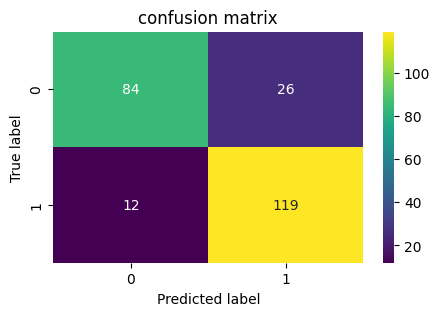

In [16]:
# Get the confusion matrix
conf_mat(y_train, final_model_preds)

In [17]:
y_train.value_counts()

target
1    131
0    110
Name: count, dtype: int64

Because we are predicting diabetes, we need to prioritize recall over precision

better to misclassify someone without diabetes to to misclassify someone with diabetes. 
We are talking about lives here

If someone without diabetes was misclassified, further tests will reveal the truth

In [18]:
# Get the prediction probabilities
final_pred_probas = cross_val_predict(final_model, X_train, y_train, cv=5, method="predict_proba")

In [19]:
final_pred_probas[:5]

array([[0.28700261, 0.71299739],
       [0.6629552 , 0.3370448 ],
       [0.82207576, 0.17792424],
       [0.94438592, 0.05561408],
       [0.0763279 , 0.9236721 ]])

In [20]:
# Get the true preds
final_pred_probas_1 = final_pred_probas[:, 1]
final_pred_probas_1[:5]

array([0.71299739, 0.3370448 , 0.17792424, 0.05561408, 0.9236721 ])

In [21]:
# Get the precision and recall at all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true=y_train, probas_pred=final_pred_probas_1)

In [22]:
precisions[:15]  # Remember precision starts off low

array([0.54356846, 0.54583333, 0.54811715, 0.55042017, 0.55274262,
       0.55508475, 0.55744681, 0.55982906, 0.56223176, 0.56465517,
       0.56709957, 0.56956522, 0.5720524 , 0.5745614 , 0.57709251])

In [23]:
recalls[:15]  # Recall start of high

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [24]:
thresholds[:15]  # the threshold has been arranged from the lowest to the highest value

array([0.00763775, 0.01146995, 0.01514261, 0.02288012, 0.02316686,
       0.02432469, 0.02744764, 0.02797292, 0.03330604, 0.0360111 ,
       0.03822639, 0.03861739, 0.03904131, 0.04049793, 0.04133717])

Pr curve is not useful in this dataset. the data is relatively balanced

In [25]:
# Create an interactive plot to visualize change in threshold values
def make_cnf_matrix(threshold):
    final_pred_probas = cross_val_predict(final_model, X_train, y_train, cv=5, method="predict_proba")
    pred_probas = final_pred_probas[:, 1]
    y_pred = pred_probas > threshold
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Classification report
    print(classification_report(y_train, y_pred))
    print(f"Roc Auc score: {roc_auc_score(y_train, y_pred)}")
    
    # Plot confusion matrix
    ax1 = axes[0]
    conf_mat = confusion_matrix(y_train, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')

    # Plot precision-recall curve
    ax2 = axes[1]
    
    fpr, tpr, thresholds = roc_curve(y_train, pred_probas)
    ax2.plot(fpr, tpr)
    
    idx = (thresholds <= threshold).argmax()
    ax2.plot([fpr[idx]], [tpr[idx]], "ko", label=f"Point at {threshold} threshold")
    ax2.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], "k:")
    ax2.plot([0.0, fpr[idx]], [tpr[idx], tpr[idx]], "k:")

    ax2.set_xticks(np.arange(0, 1.1, 0.1))
    ax2.set_yticks(np.arange(0, 1.1, 0.1))
    ax2.set_xlabel('False Positive Rate (Fall-Out)')
    ax2.set_ylabel('True Positive Rate (Recall)')
    ax2.legend(loc="lower right")
    ax2.set_title('FPR vs TPR')

    plt.tight_layout()
    plt.show()

thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

Im settling for 0.4 threshold value

In [26]:
# Now fit tthe data
final_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'cp', 'trestbps',
                                                   'chol', 'restecg', 'thalach',
                                                   'oldpeak', 'slope', 'ca',
                                                   'thal']),
                                                 ('cats',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['sex', 'fbs', 'exang'])])),
                ('logreg',
                 LogisticRegression(C=0.2, l1_ratio=0.6, max_iter=500,
                                    n_jobs=-1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [27]:
### Test prediction probas
test_pred_probas = final_model.predict_proba(X_test)[:, 1]
test_pred_probas[:5]

array([0.22066802, 0.26904663, 0.02977006, 0.64345544, 0.6772934 ])

In [28]:
# Test predictions considering the threshold value i.e 0.4
test_preds = test_pred_probas > 0.4
test_preds[:5]

array([False, False, False,  True,  True])

              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



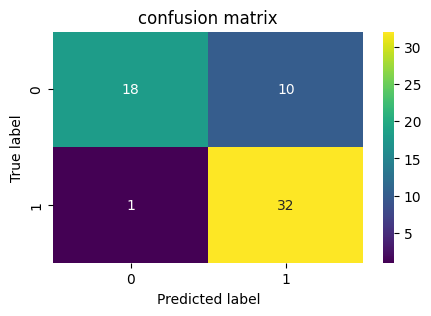

In [29]:
# Classification report
print(classification_report(y_test, test_preds))
conf_mat(y_test, test_preds)

97% recall, the model seems to be performing well. We only misclassified one patient that has diabetes as not having diabetes

In [30]:
# # Pickle the final model

# with open ("final_log_reg_model", "wb") as f:
#     pickle.dump(final_model, f)

### Communication

In [32]:
final_model.named_steps

{'prep': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['age', 'cp', 'trestbps', 'chol', 'restecg',
                                   'thalach', 'oldpeak', 'slope', 'ca',
                                   'thal']),
                                 ('cats',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(sparse_output=False))]),
                                  ['sex', 'fbs', 'exang'])]),
 'logreg': LogisticRegression(C=0.2, l1_ratio=0.6, max_iter=500, n_jobs=-1,
                    penalty='elasticnet', random_state=42, solver='saga')}

In [35]:
# Get the featuers and their importances
features = final_model.named_steps["prep"].get_feature_names_out()
importances = final_model.named_steps['logreg'].coef_[0]
print(importances)

[ 0.          0.75938403 -0.14022855 -0.21111221  0.15898583  0.40224432
 -0.57492549  0.18007085 -0.45075955 -0.47252521  0.35580621 -0.3523334
  0.          0.          0.28568334 -0.28214094]


In [41]:
# Get the minimum and maximum and maximum importances
importances.min(), importances.max()

(-0.574925488945282, 0.7593840262908779)

The coefficients of a logistic regression model are not the coefficient as we see in a linear regression.
Logistic regression is the linear equation wrapped around a sigmoid finction

So we have to take the exponential and get the odds ratio

In [38]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

num__oldpeak     0.562747
num__thal        0.623426
num__ca          0.637144
cats__sex_1      0.703046
cats__exang_1    0.754167
dtype: float64

In [39]:
odds_ratios.min(), odds_ratios.max()

(0.5627467981023041, 2.136959504135115)

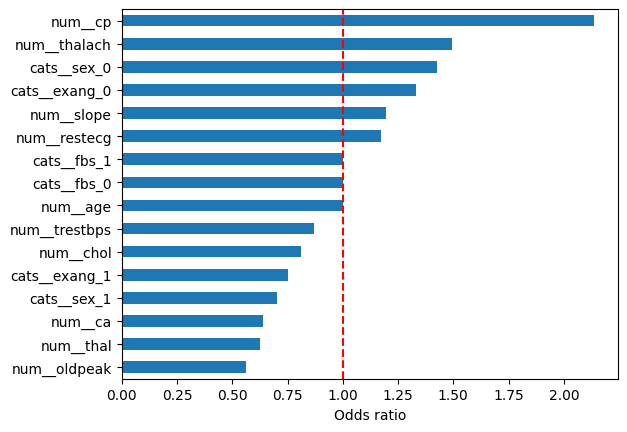

In [49]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail(17).plot(
    kind='barh', xlabel=("Odds ratio")
)
plt.axvline(x=1, color='red', linestyle='--');

Our cp(chest pain type) is the most predictive. its at 2. 
What it means is that the odds of having a heart disease is when you have chest pain is 2 times greater than when you have any other symptom in the dataset

Any odds that is  > 1 indicates features that are most associated with increase in heart disease

Can we establish a causal relationship between sex and heart disease. or is it beacluse there aer ots of 1 gender compared to others in the dataset?

The problem with observational data is the presence of lurking variables that migh affect analysis?